# Implementing FIR filters
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>
<br />

Digital filters are fully described by their constant-coefficient difference equation (CCDE) and a CCDE can be easily translated into a few lines of code to obtain a simple filter implementation. 

In the case of FIR filters the coefficients in the CCDE coincide with the values of the impulse response, so that FIR filters can also be implemented as a convolution (aka an inner product) or by performing a multiplication in the frequency domain, as we will see shortly.

When applying an FIR filter to a finite-length input, we also need to be mindful of the so called "border effects", that is, of the output samples that involve data indices outside of the input range. 

In this notebook we will look at different FIR implementations and at the associated caveats.

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## 1. FIR implementation for real-time use

The classic way to implement a causal filter that works in real time is the _"one-in one-out"_ approach. This will require the algorithm to keep track of past input samples and we can achieve that by implementing a persistent delay line. In Python we can either define a class or use function attributes; classes are tidier and reusable:

In [5]:
class FIR_loop():
    def __init__(self, h):
        self.h = h
        self.ix = 0
        self.M = len(h)
        self.buf = np.zeros(self.M)

    def filter(self, x):
        y = 0
        self.buf[self.ix] = x
        for n in range(0, self.M):
            y += self.h[n] * self.buf[(self.ix+self.M-n) % self.M]
        self.ix = (self.ix + 1) % self.M
        return y

In [6]:
# simple moving average:
h = np.ones(5)/5

# instantiate a moving average FIR and use it
f = FIR_loop(h)
for n in range(0, 10):
    print(round(f.filter(n), 3),  end='  ')

0.0  0.2  0.6  1.2  2.0  3.0  4.0  5.0  6.0  7.0  

While there's nothing wrong with the above implementation, when the data to be filtered is known in advance, it makes no sense to explicitly iterate over each data point and it's better to use an optimized built-in function to perform a convolution; in Numpy, such a command is `convolve`. When we do so, however, we need to take border effects into account.

## 2. Offline implementations and border effects

When filtering a finite-length data vector, we need to decide how to deal with the "out of range" indexes that appear in the convolution. Recall that the $n$-th output sample is defined as

$$
    y[n] = \sum_{k=-\infty}^{\infty} h[k]x[n-k]
$$

If the filter is an $M$-tap FIR, $h[n]$ is nonzero only fo $0 \leq n \leq M-1$; we can therefore write 

$$
    y[n] = \sum_{k=0}^{M-1} h[k]x[n-k]
$$

Now assume that the input is a length-$N$ signal, namely, $x[n]$ is defined only for $0 \leq n \le N$; also, we can safely consider $N > M$, otherwise exchange the roles of $x$ and $h$. Then $y[n]$ can be computed only only for $M - 1 \le n \le N-1$ since, for any other value of $n$, the sum will contain a term $x[n-k]$ where $n-k$ is outside of the valid range of indexes for the input. 

This means that, if we start with an $N$-point input, we can  fully compute only $N-M+1$ output samples. While this may not be a problem in some applications, especially if $N \gg M$, it certainly is troublesome if repeated filtering operations end up "chipping away" at the signal little by little.

The solution is to "embed" the finite-length input data signal into an infinite-length sequence and, as always, the result will depend on the embedding that we choose, that is, finite support extension or periodization. Incidentally, please note that an FIR impulse response is by definition infinite sequence, albeit a finite-support one, since it is the response of the filter to the sequence $\delta[n]$. 

Independently of the method, the embedding will always create "artificial" data points that are said to suffer from **border effects**. We will now explore these effects using a moving average filter and a finite-length input with a simple shape.

/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/4239263413.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(x, use_line_collection=True);


signal length: 21


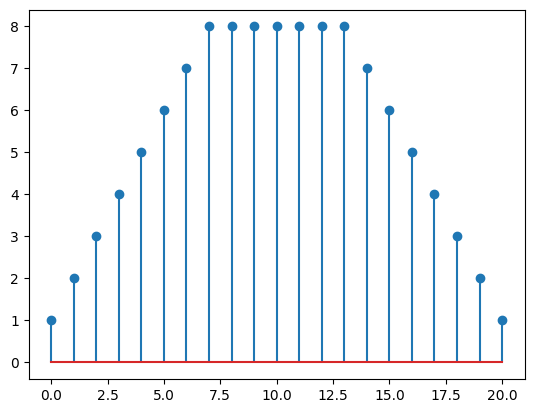

In [7]:
# let's use a simple moving average:
M = 5
h = np.ones(M)/float(M)

# let's build a signal with a ramp and a plateau
x = np.concatenate((np.arange(1, 9), np.ones(5) * 8, np.arange(8,0,-1)))
plt.stem(x, use_line_collection=True);

print(f'signal length: {len(x)}')

### 2.1. No border effects (output shorter than input)

We may choose to accept the loss of data points and use only the $N-M+1$ output samples that correspond to a full overlap between the input data and the impulse response. This can be achieved by selecting `mode='valid'` in `correlate`:

signal length: 17


/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/2821422260.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);


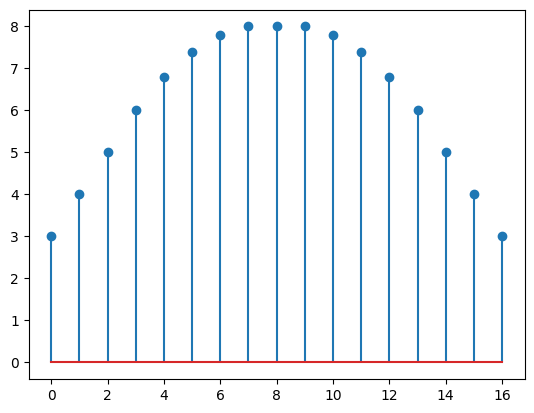

In [8]:
y = np.convolve(x, h, mode='valid')
print(f'signal length: {len(y)}')
plt.stem(y, use_line_collection=True);

### 2.2. finite-support extension

#### 2.2.1. Full convolution

By embedding the input into a finite-support signal, the convolution sum is now well defined for all values of $n$, which now creates a new problem: the output will be potentially nonzero for all values of $n$ for which $x[n-k]$ is nonzero, that is for $0 \le n \le N+M-1$: we end up with a *longer* support for the output sequence. This is the default in `correlate`  and corresponds to `mode='full'`:

signal length: 25


/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/610048610.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);


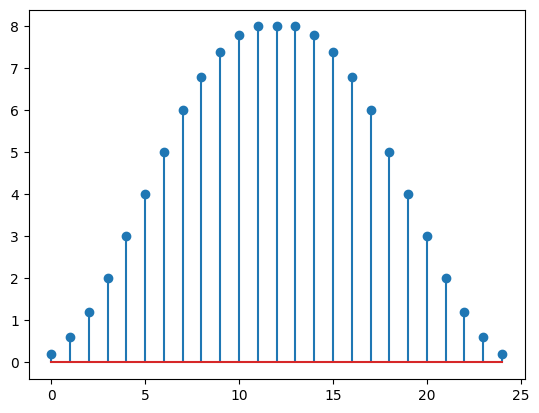

In [9]:
y = np.convolve(x, h, mode='full')
print(f'signal length: {len(y)}')
plt.stem(y, use_line_collection=True);

#### 2.2.2 Truncated convolution

If we want to preserve the same length for input and output, we need to truncate the result. You can keep the *first* $N$ samples and discard the tail:

signal length: 21


/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/3735845819.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);


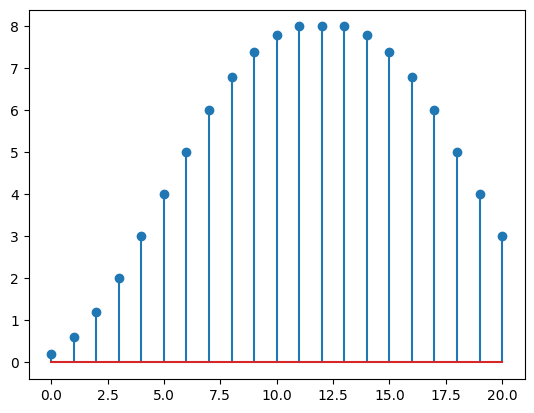

In [10]:
y = np.convolve(x, h, mode='full')[:len(x)]
print(f'signal length: {len(y)}')
plt.stem(y, use_line_collection=True);

Note that this corresponds exactly to the online implementation of the FIR filter, stopped after $N$ input points

/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/3701087767.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);


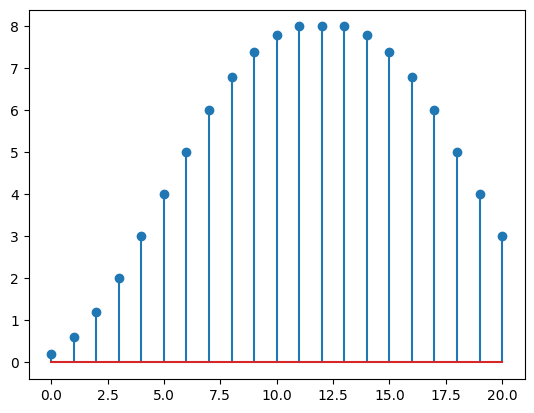

In [11]:
f = FIR_loop(h)
y1 = np.zeros(len(x))
for n, xn in enumerate(x):
    y1[n] = f.filter(xn)   
plt.stem(y, use_line_collection=True);

Alternatively, you can discard half the extra samples from the beginning and half from the end of the output and distribute the border effect evenly; this is achieved in `correlate`  by setting `mode='same'`: 

signal length: 21


/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/2729069827.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);


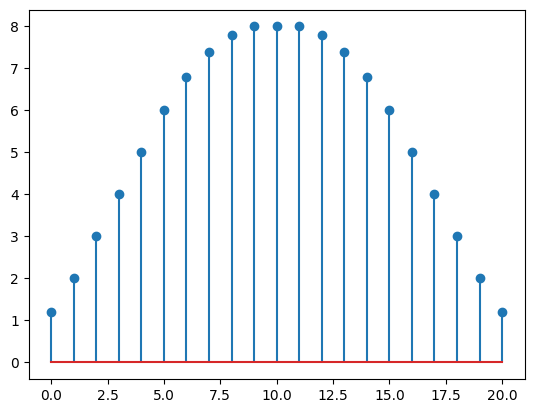

In [12]:
y = np.convolve(x, h, mode='same')
print(f'signal length: {len(y)}')
plt.stem(y, use_line_collection=True);

### 2.3. Periodic extension 

The other way in which we can embed a length-$N$ signal into a sequence is to build an $N$-periodic extension $\tilde{x}[n] = x[n \mod N]$. The convolution in this case will return an $N$-periodic output:

$$
    \tilde{y}[n] = \sum_{k=0}^{M-1} h[k]\tilde{x}[n-k]
$$

#### 2.3.1. Circular convolution

We can easily implement a circular convolution using `convolve`: since the overlap between time-reversed impulse response and input is already good for the last $N-M$ points of the output, we just need to consider two periods of the input to compute the first $M$: 

In [13]:
def cconv(x, h):
    # as before, we assume len(h) < len(x)
    N = len(x)
    xp = np.concatenate((x, x))
    # full convolution
    y = np.convolve(xp, h)
    return y[N:2*N]

signal length: 21


/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/4181251625.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);


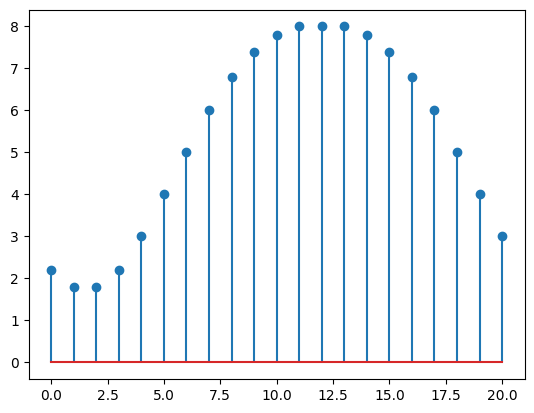

In [14]:
y = cconv(x, h)
print(f'signal length: {len(y)}')
plt.stem(y, use_line_collection=True);

OK, clearly the result is not necessarily what we expected; note however that in both circular and "normal" convolution, you still have $M-1$ output samples "touched" by border effects, it's just that the border effects act differently in the two cases.

#### 2.3.2. Normal convolution via circular convolution

Interestingly, if you zero-pad the input signal with $M-1$ zeros, you can still obtain a "normal" convolution using a circular convolution:

signal length: 25


/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/1795087695.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);
/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/1795087695.py:6: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y - np.convolve(x, h, mode='full'), markerfmt='ro', use_line_collection=True);


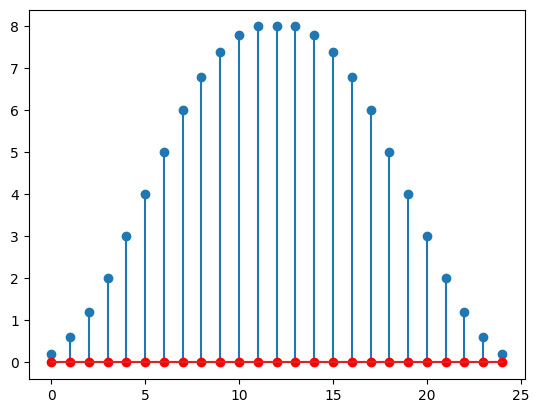

In [15]:
y = cconv(np.concatenate((x, np.zeros(M-1))), h)
print(f'signal length: {len(y)}')
plt.stem(y, use_line_collection=True);

# plot in red the *difference* with the standard conv
plt.stem(y - np.convolve(x, h, mode='full'), markerfmt='ro', use_line_collection=True);

This seems to be a completely redundant way of convolving two signals but it is interesting? because circular convolution can be efficiently implemented in the frequency-domain, as we will now show.

## 3. Offline FIR implementations using the FFT

The convolution theorem states that, for infinite sequences, convolution in the time domain corresponds to multiplication in the frequency domain. With this, we could compute the output of a filter using the inverse Fourier transform like so:

$$
    (x\ast y)[n] = \ast{IDTFT}\{X(e^{j\omega})Y(e^{j\omega})\}[n]
$$

Can we apply this result to the finite-length case? In other words, what is the inverse DFT of the product of two DFTs? Let's see:

\begin{align}
    \sum_{k=0}^{N-1}X[k]Y[k]e^{j\frac{2\pi}{N}nk} &= \sum_{k=0}^{N-1}\sum_{p=0}^{N-1}x[p]e^{-j\frac{2\pi}{N}pk}\sum_{q=0}^{N-1}y[q]e^{-j\frac{2\pi}{N}qk} \,e^{j\frac{2\pi}{N}nk} \\
    &= \sum_{p=0}^{N-1}\sum_{q=0}^{N-1}x[p]y[q]\sum_{k=0}^{N-1}e^{j\frac{2\pi}{N}(n-p-q)k} \\
    &= N\sum_{p=0}^{N-1}x[p]y[(n-p) \mod N]
\end{align}

The results follows from the fact that $\sum_{k=0}^{N-1}e^{j\frac{2\pi}{N}(n-p-q)k}$ is nonzero only for $n-p-q$ multiple of $N$; as $p$ varies from $0$ to $N-1$, the corresponding value of $q$ between $0$ and $N$ that makes $n-p-q$ multiple of $N$ is $(n-p) \mod N$.

So the fundamental result is: **the inverse DFT of the product of two DFTs is the circular convolution of the underlying time-domain sequences!**


To apply this result to FIR filtering, the first step is to choose the space for the DFTs. In our case we have a finite-length data vector of length $N$ and a finite-support impulse response of length $M$ with $M<N$ so let's operate in $\mathbb{C}^N$ by zero-padding the impulse response to size $N$. Also, we most likely want the normal convolution, so let's zero-pad both signals by an additional $M-1$ samples as explained in Section 2.3.2 above.

In [16]:
def DFTconv(x, h, mode='full'):
    # we want the compute the full convolution
    N = len(x)
    M = len(h)
    X = np.fft.fft(x, n=N+M-1)
    H = np.fft.fft(h, n=N+M-1)
    # we're using real-valued signals, so drop the imaginary part
    y = np.real(np.fft.ifft(X * H))
    if mode == 'valid':
        # only N-M+1 points, starting at M-1
        return y[M-1:N]
    elif mode == 'same':
        return y[int((M-1)/2):int((M-1)/2+N)]
    else:
        return y

Let's verify that the results are the same

signal length: 17
signal length: 17


/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/3630221398.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);
/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/3630221398.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, markerfmt='ro', use_line_collection=True);


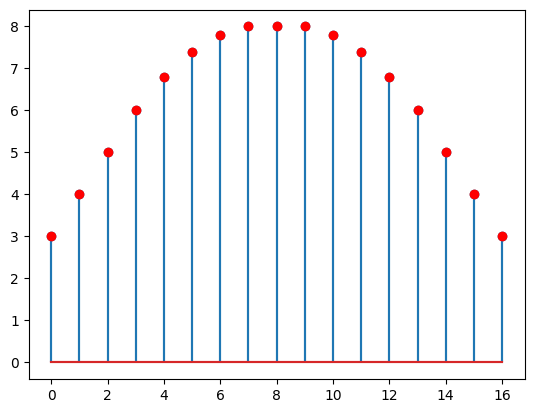

In [17]:
y = np.convolve(x, h, mode='valid')
print(f'signal length: {len(y)}')
plt.stem(y, use_line_collection=True);

y = DFTconv(x, h, mode='valid')
print(f'signal length: {len(y)}')
plt.stem(y, markerfmt='ro', use_line_collection=True);

signal length: 21
signal length: 21


/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/1207664765.py:3: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, use_line_collection=True);
/var/folders/_y/y30mq8p10d10z7ctdz64tjqc0000gn/T/ipykernel_92386/1207664765.py:7: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(y, markerfmt='ro', use_line_collection=True);


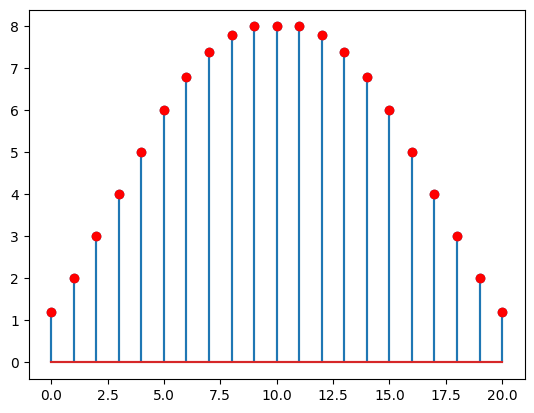

In [18]:
y = np.convolve(x, h, mode='same')
print(f'signal length: {len(y)}')
plt.stem(y, use_line_collection=True);

y = DFTconv(x, h, mode='same')
print(f'signal length: {len(y)}')
plt.stem(y, markerfmt='ro', use_line_collection=True);

### 3.1. Computational requirements

Of course the question at this point is: why go through the trouble of taking DFTs if all we want is the standard convolution? The answer is: **computational efficiency.**

If you look at the convolution sum, each output sample requires $M$ multiplications (and $M-1$ additions but let's just consider multiplications). In order to filter an $N$-point signal we will need $NM$ multiplications. Assume $N \approx M$ and you can see that the computational requirements are on the order of $M^2$. If we go the DFT route using an efficient FFT implementation we have approximately: 

 * $M\log_2 M$ multiplication to compute $H[k]$
 * $M\log_2 M$ multiplication to compute $X[k]$
 * $M\log_2 M$ multiplication to compute $X[k]H[k]$
 * $M\log_2 M$ multiplication to compute the inverse DFT
 
Even considering that we now have to use complex multiplications (which will cost twice as much), we can estimate the cost of the DFT based convolution at around $8M\log_2M$, which is smaller than $M^2$ as soon as $M>44$.  

In practice, the data vector is much longer than the impulse response so that filtering via standard convolution requires on the order of $MN$ operations. Two techniques, called [Overlap Add](https://en.wikipedia.org/wiki/Overlap%E2%80%93add_method) and [Overlap Save](https://en.wikipedia.org/wiki/Overlap%E2%80%93save_method)
can be used to divide the convolution into $N/M$ independent convolutions between $h[n]$ and an $M$-sized piece of $x[n]$; FFT-based convolution can then be used on each piece. While the exact cost per sample of each technique is a bit complicated to estimate, as a rule of thumb **as soon as the impulse response is longer than 50 samples, it's more convenient to use DFT-based filtering.** 

# ---------------------------------




### Did you like this Notebook?
Yes, no, maybe? Why don't you give us some feedback using the completely anonymous form below? Thank you!

In [ ]:
from IPython.display import IFrame
IFrame('https://www.surveymonkey.com/r/NOTOSURVEY?notebook_set=COM303&notebook_id=FIRImplementation', 600, 800)